In [128]:
# solutions.py

import pyspark
from pyspark.sql import SparkSession
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator as MCE
from collections import Counter


In [18]:
import subprocess

# Command to check Java version
java_version_cmd = "java -version"

# Execute the command and capture the output
process = subprocess.Popen(java_version_cmd, shell=True, stderr=subprocess.PIPE)
stderr = process.communicate()[1]

# Decode and print the output
java_version_output = stderr.decode("utf-8")
java_version_output


'openjdk version "1.8.0_402"\nOpenJDK Runtime Environment (Zulu 8.76.0.17-CA-macos-aarch64) (build 1.8.0_402-b06)\nOpenJDK 64-Bit Server VM (Zulu 8.76.0.17-CA-macos-aarch64) (build 25.402-b06, mixed mode)\n'

In [19]:
spark = SparkSession\
         .builder\
         .appName("app_name")\
         .getOrCreate()

titanic = spark.sparkContext.textFile("titanic.csv")

print(titanic.take(2))
spark.stop()

['1,1,"Allen, Miss. Elisabeth Walton",female,29.0,0,0,211.3375', '1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,151.55']


In [20]:
def word_count(filename='huck_finn.txt'):
    """
    A function that counts the number of occurrences unique occurrences of each
    word. Sorts the words by count in descending order.
    Parameters:
        filename (str): filename or path to a text file
    Returns:
        word_counts (list): list of (word, count) pairs for the 20 most used words
    """ 
    spark = SparkSession\
        .builder\
        .appName("Word Count")\
        .getOrCreate()
    rdd = spark.sparkContext.textFile(filename)
    word_counts = rdd.flatMap(lambda line: line.split()) \
        .map(lambda word: (word, 1)) \
        .reduceByKey(lambda a, b: a + b) \
        .sortBy(lambda x: x[1], ascending=False) \
        .take(20)
    spark.stop()
    return word_counts


In [11]:
word_count()

[('and', 6049),
 ('the', 4706),
 ('I', 3045),
 ('a', 2936),
 ('to', 2903),
 ('was', 1942),
 ('of', 1732),
 ('it', 1428),
 ('he', 1373),
 ('in', 1368),
 ('you', 1022),
 ('that', 892),
 ('for', 828),
 ('on', 772),
 ('all', 742),
 ('but', 738),
 ('up', 701),
 ('we', 673),
 ('out', 649),
 ('so', 625)]

In [21]:
### Problem 2
def monte_carlo(n=10**5, parts=6):
    """
    Runs a Monte Carlo simulation to estimate the value of pi.
    Parameters:
        n (int): number of sample points per partition
        parts (int): number of partitions
    Returns:
        pi_est (float): estimated value of pi
    """
    spark = SparkSession\
        .builder\
        .appName("Monte Carlo")\
        .getOrCreate()
    rdd = spark.sparkContext.parallelize(range(parts)) \
        .map(lambda x: np.random.rand(n, 2)) \
        .map(lambda x: np.sum(np.sum(x**2, axis=1) < 1)) \
        .reduce(lambda a, b: a + b)
    pi_est = 4 * rdd / (n * parts)
    spark.stop()
    return pi_est

In [22]:
monte_carlo()

3.13584

In [90]:
def titanic_df(filename='titanic.csv'):
    """
    Calculates some statistics from the titanic data.
    
    Returns: the number of women on-board, the number of men on-board,
             the survival rate of women, 
             and the survival rate of men in that order.
    """
    # create SparkSession
    spark = SparkSession\
        .builder\
        .appName("Titanic Df")\
        .getOrCreate()
    
    # create schema
    schema = ('survived INT, pclass INT, name STRING, sex STRING, '
            'age FLOAT, sibsp INT, parch INT, fare FLOAT'
            )

    # read csv file
    titanic = spark.read.csv(filename,schema=schema)
    
    # create temporary view
    titanic.createOrReplaceTempView("titanic")

    # calculate statistics
    total_count = spark.sql(
        "SELECT sex, COUNT(*) AS count\
        FROM titanic\
        GROUP BY sex"
    ).collect()

    survival_rate = spark.sql(
        "SELECT sex, AVG(survived) as survival_rate\
        FROM titanic\
        GROUP BY sex"
    ).collect()

    # stop SparkSession
    spark.stop()

    # return statistics
    return (total_count[0][1], total_count[1][1], survival_rate[0][1], survival_rate[1][1])


In [91]:
titanic_df()

[Row(sex='female', count=388), Row(sex='male', count=657)] [Row(sex='female', survival_rate=0.7525773195876289), Row(sex='male', survival_rate=0.2054794520547945)]


(388, 657, 0.7525773195876289, 0.2054794520547945)

In [126]:
def crime_and_income(crimefile='london_crime_by_lsoa.csv',
                     incomefile='london_income_by_borough.csv', major_cat='Robbery'):
    """
    Explores crime by borough and income for the specified major_cat
    Parameters:
        crimefile (str): path to csv file containing crime dataset
        incomefile (str): path to csv file containing income dataset
        major_cat (str): major or general crime category to analyze
    returns:
        (ndarray): borough names sorted by percent months with crime, descending
    """
    # Create SparkSession
    spark = SparkSession.builder.appName("Crime and Income Analysis").getOrCreate()
    
    # Load Data
    crime_data = spark.read.csv(crimefile, header=True, inferSchema=True)
    income_data = spark.read.csv(incomefile, header=True, inferSchema=True)

    # Create temporary views
    crime_data.createOrReplaceTempView("crime")
    income_data.createOrReplaceTempView("income")

    # Create joined table
    df = spark.sql(
        f"SELECT crime.borough, `income`.`median-08-16`, SUM(crime.value) AS major_cat_total_crime\
        FROM crime\
        JOIN income\
        ON crime.borough = income.borough\
        WHERE major_category = '{major_cat}'\
        GROUP BY crime.borough, `income`.`median-08-16`\
        ORDER BY major_cat_total_crime DESC"
    )

    numpy_array = np.array(df.collect())

    print(numpy_array)

    # Stop SparkSession
    spark.stop()
# Function to format tick labels
    def custom_formatter(x, pos):
        return f'{x/10**3:.0f}K' if x >= 1000 else f'{x:.0f}'

    formatter = FuncFormatter(custom_formatter)

    # Create scatter plot of data, rounded to the hundreds
    plt.scatter(numpy_array[:, 1], numpy_array[:, 2])
    plt.xlabel('Median Income')
    plt.ylabel('Total Crime')
    plt.title('Total Crime vs Median Income')

    # Set custom formatters for axes
    plt.gca().xaxis.set_major_formatter(formatter)
    plt.gca().yaxis.set_major_formatter(formatter)

    plt.show()

    # return array
    return numpy_array[:, 0]


[['Lambeth' '25412.5' '18408']
 ['Newham' '18750.0' '16913']
 ['Southwark' '24912.5' '16153']
 ['Westminster' '33675.0' '15752']
 ['Croydon' '23537.5' '12645']
 ['Brent' '20700.0' '12473']
 ['Waltham Forest' '21087.5' '10606']
 ['Lewisham' '23387.5' '10455']
 ['Haringey' '23050.0' '10084']
 ['Tower Hamlets' '25337.5' '10050']
 ['Ealing' '22437.5' '9568']
 ['Camden' '30775.0' '9286']
 ['Enfield' '22775.0' '9059']
 ['Hackney' '24100.0' '8975']
 ['Islington' '28125.0' '8736']
 ['Wandsworth' '30462.5' '8398']
 ['Redbridge' '23750.0' '7688']
 ['Barnet' '25250.0' '7374']
 ['Barking and Dagenham' '20250.0' '6105']
 ['Hillingdon' '23525.0' '5663']
 ['Greenwich' '22662.5' '5430']
 ['Hammersmith and Fulham' '28100.0' '5279']
 ['Bromley' '26375.0' '4868']
 ['Hounslow' '22700.0' '4847']
 ['Kensington and Chelsea' '35812.5' '4744']
 ['Harrow' '23975.0' '4242']
 ['Merton' '25750.0' '4021']
 ['Havering' '23387.5' '3089']
 ['Bexley' '22900.0' '2338']
 ['Sutton' '24587.5' '2308']
 ['Kingston upon Thame

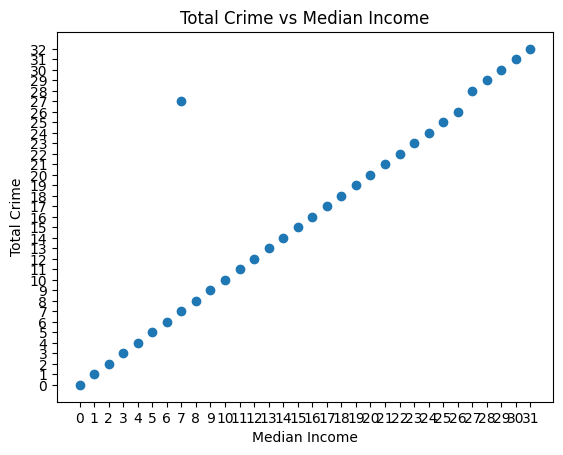

array(['Lambeth', 'Newham', 'Southwark', 'Westminster', 'Croydon',
       'Brent', 'Waltham Forest', 'Lewisham', 'Haringey', 'Tower Hamlets',
       'Ealing', 'Camden', 'Enfield', 'Hackney', 'Islington',
       'Wandsworth', 'Redbridge', 'Barnet', 'Barking and Dagenham',
       'Hillingdon', 'Greenwich', 'Hammersmith and Fulham', 'Bromley',
       'Hounslow', 'Kensington and Chelsea', 'Harrow', 'Merton',
       'Havering', 'Bexley', 'Sutton', 'Kingston upon Thames',
       'Richmond upon Thames', 'City of London'], dtype='<U32')

In [129]:
crime_and_income()

In [140]:
def titanic_classifier(filename='titanic.csv'):
    """
    Implements a classifier model to predict who survived the Titanic.
    Parameters:
        filename (str): path to the dataset
    Returns:
        metrics (tuple): a tuple of metrics gauging the performance of the model
            ('accuracy', 'weightedRecall', 'weightedPrecision')
    """

    # create SparkSession
    spark = SparkSession\
        .builder\
        .appName("Titanic Classifier")\
        .getOrCreate()
    
    # create schema
    schema = ('survived INT, pclass INT, name STRING, sex STRING, '
            'age FLOAT, sibsp INT, parch INT, fare FLOAT'
            )

    # read csv file
    titanic = spark.read.csv(filename,schema=schema)

    # convert the 'sex' column to a numeric column
    sex_binary = StringIndexer(inputCol='sex', outputCol='sex_binary')

    onehot = OneHotEncoder(inputCols=['pclass'], outputCols=['pclass_onehot'])

    # create a feature vector
    features = ['sex_binary', 'pclass_onehot', 'age', 'sibsp', 'parch', 'fare']
    feature_vector = VectorAssembler(inputCols=features, outputCol='features')

    # create a pipeline
    pipeline = Pipeline(stages=[sex_binary, onehot, feature_vector])
    titanic = pipeline.fit(titanic).transform(titanic)

    # split the data into training and test sets
    train, test = titanic.randomSplit([0.75, 0.25], seed=11)

    # create a random forest classifier
    rf = RandomForestClassifier(featuresCol='features', labelCol='survived', seed=42)

    # create a parameter grid
    paramGrid = ParamGridBuilder().addGrid(rf.numTrees, [10, 100]).build()

    # create an evaluator
    evaluator = MCE(labelCol='survived', metricName='accuracy')

    # create a cross validator
    tvs = TrainValidationSplit(estimator=rf,
                                 estimatorParamMaps=paramGrid,
                                 evaluator=evaluator,
                                 trainRatio=0.8,
                                 seed=42)
    
    # fit the model
    clf = tvs.fit(train)

    # make predictions
    predictions = clf.transform(test)

    # calculate metrics
    metrics = (evaluator.evaluate(predictions),
                MCE(labelCol='survived', metricName='weightedRecall').evaluate(predictions),
                MCE(labelCol='survived', metricName='weightedPrecision').evaluate(predictions))
    

    # stop SparkSession
    spark.stop()

    # return metrics
    return metrics

In [139]:
titanic_classifier()

(0.7723214285714286, 0.7723214285714286, 0.7713789969429068)